# Лабораторна №3

Імпортуємо всі потрібні бібліотеки для побудови графіків та нейронних мереж різних видів.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, MaxPooling2D, Conv2D

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling1D

import warnings
warnings.filterwarnings('ignore')

## Повнозв'язна нейронна мережа

Для цього завдання імпортуємо вже оброблений датасет з позаминулої лабораторної.

In [2]:
# Завантаження даних
data = pd.read_csv('ChessDataClean.csv')
data.head()

,turns,victory_status,winner,white_rating,black_rating,opening_moves,opening_shortname,opening_variation,time
0,61,0,1,1919,1798,2,Dutch Defense,#2,10
1,86,3,0,1195,1123,4,Latvian Gambit,#2,10
2,27,0,0,1867,1932,9,Sicilian Defense,Accelerated Dragon,10
3,79,0,1,1823,1770,14,King's Indian Defense,Saemisch Variation,10
4,37,0,1,1371,1193,3,King's Pawn Game,Leonardis Variation,10


Будуємо модель зі 128 нейронами на першому шарі і на кожному наступному відкинемо половину. Також застосуємоо ранню зупинку для запобігання перенавчання.

In [3]:
# Вибір вхідних ознак і міток
features = data[['white_rating', 'black_rating', 'time', 'opening_moves', 'victory_status']]
labels = data['winner']

# Розділення даних на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Стандартизація ознак
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Створення та компіляція моделі
model = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Використовуйте EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Навчання моделі з валідацією та EarlyStopping
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

# Оцінка моделі на тестовому наборі
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/50
201/201 [==============================] - 1s 3ms/step - loss: 0.8324 - accuracy: 0.5640 - val_loss: 0.7481 - val_accuracy: 0.6274
Epoch 2/50
201/201 [==============================] - 0s 2ms/step - loss: 0.7674 - accuracy: 0.5888 - val_loss: 0.7033 - val_accuracy: 0.6174
Epoch 3/50
201/201 [==============================] - 0s 2ms/step - loss: 0.7211 - accuracy: 0.6058 - val_loss: 0.6654 - val_accuracy: 0.6330
Epoch 4/50
201/201 [==============================] - 0s 2ms/step - loss: 0.6853 - accuracy: 0.6112 - val_loss: 0.6360 - val_accuracy: 0.6642
Epoch 5/50
201/201 [==============================] - 0s 2ms/step - loss: 0.6593 - accuracy: 0.6356 - val_loss: 0.6174 - val_accuracy: 0.6654
Epoch 6/50
201/201 [==============================] - 0s 2ms/step - loss: 0.6425 - accuracy: 0.6494 - val_loss: 0.6157 - val_accuracy: 0.6754
Epoch 7/50
201/201 [==============================] - 0s 2ms/step - loss: 0.6419 - accuracy: 0.6462 - val_loss: 0.6119 - val_accuracy: 0.6636
Epoch 

Бачимо не дуже високу точність, але така точність зумовлена характером даних, що було виявлено в позаминулій лабораторній. Найкраща точність була приблизно 67% і отримана за допомогою випадкового лісу. 

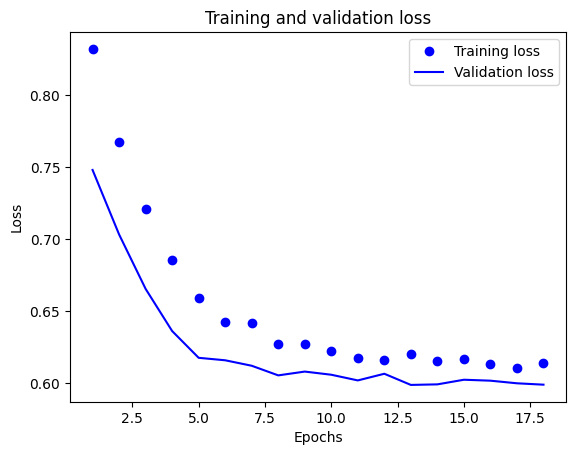

In [4]:
# Візуалізація результатів
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

За допомогою графіку також можна побачити, що оптимальна кількість епох 24, як і вийшло в моделі.

## Згорткова нейронна мережа

Завантажимо датасет з картинками панд та ведмедів.

In [5]:
img_size = 128  

Train = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\User\Desktop\Data Analysis\PandasBears\Train",
    shuffle=True,
    image_size=(img_size, img_size)
)

Test = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\User\Desktop\Data Analysis\PandasBears\Test",
    shuffle=True,
    image_size=(img_size, img_size)
)

Found 500 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


Датасет одразу розділений на тренувальний та тестовий, тому подивимось присутні там класи.

In [6]:
class_names = Train.class_names
class_names

['Bears', 'Pandas']

In [7]:
Test.class_names

['Bears', 'Pandas']

Нормалізуємо розміри картинок та значення пікселів.

In [8]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(img_size,img_size),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
])

Будуємо декілька згорткових шарів і додаємо в кінець повнозв'язний.

In [9]:
model = Sequential()
model.add(resize_and_rescale)
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(img_size,img_size)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [10]:
history= model.fit(Train,
         epochs = 3,
         verbose = 1,
         batch_size = 32,
         validation_data = Test)

Epoch 1/3
16/16 [==============================] - 7s 372ms/step - loss: 0.5719 - accuracy: 0.6740 - val_loss: 0.3253 - val_accuracy: 0.8300
Epoch 2/3
16/16 [==============================] - 6s 382ms/step - loss: 0.1082 - accuracy: 0.9740 - val_loss: 0.0370 - val_accuracy: 0.9900
Epoch 3/3
16/16 [==============================] - 6s 373ms/step - loss: 0.0356 - accuracy: 0.9920 - val_loss: 0.0089 - val_accuracy: 1.0000


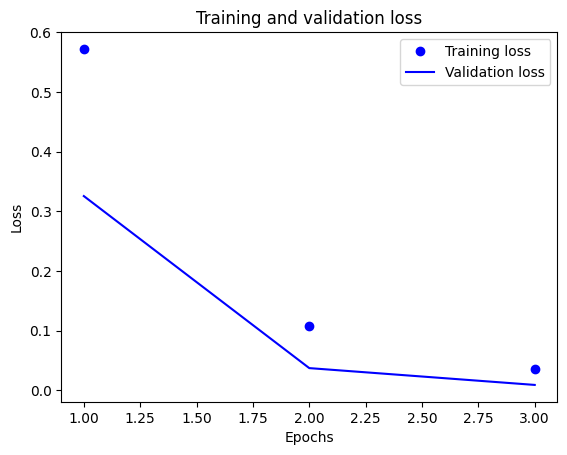

In [11]:
# Візуалізація результатів
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Бачимо майже повну точність та оптимальну кількість епох 5.

In [12]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


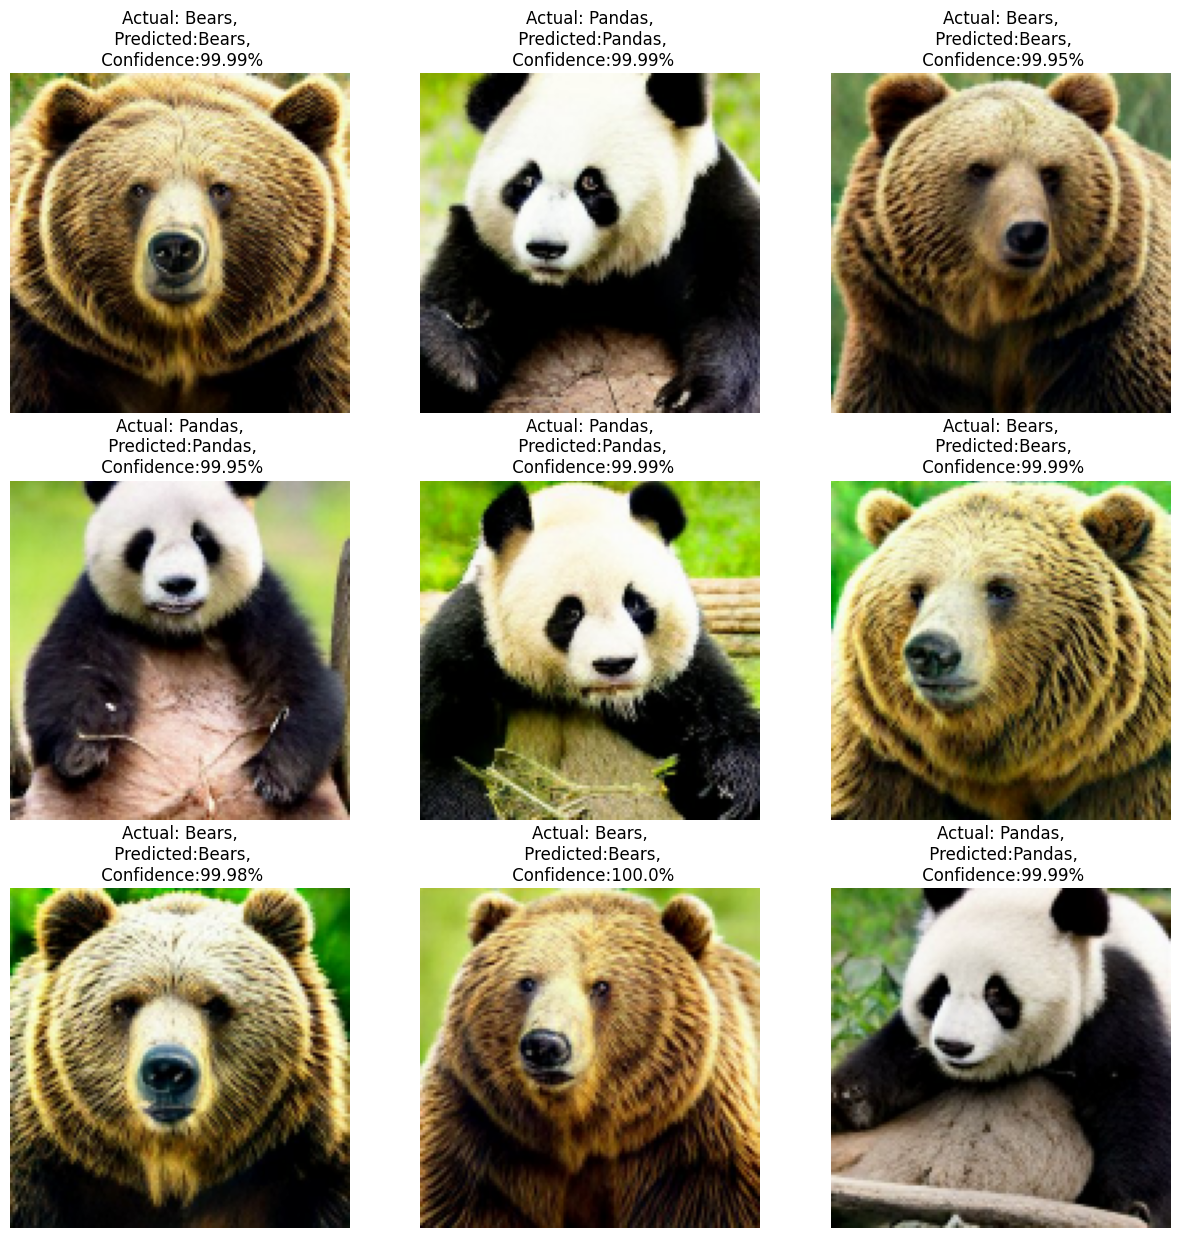

In [13]:
plt.figure(figsize=(15,15))
for images, labels in Test.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis(False)
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}%")

## Рекурентна нейронна мережа

Завантажуємо з минулої лабораторної оброблений датасет.

In [14]:

text = pd.read_csv('AmazonClean.csv')

df = text

# Ознаки (текстова змінна)
corpus = df['lemmas']  # Перевірте, чи 'lemmas' - це правильна назва стовпця

corpus.tail(100)

1364    kent electric chop black smart efficient kitch...
1365    usb degree centigrade degree centigrade cable ...
1366    anion function air negative ion restore atmosp...
1367    resolution hd ready ten refresh rate sixty her...
1368    resolution k ultra hd ten refresh rate sixty h...
                              ...                        
1459    battery operated milk frother easy control eas...
1460    khaitan orfin fan heater home kitchen powerful...
1461    make delicious milk foam cream pitcher drink h...
1462    💎 fastest charge iphone usb degree centigrade ...
1463    ✔quick electric hot water pat heating tube hig...
Name: lemmas, Length: 100, dtype: object

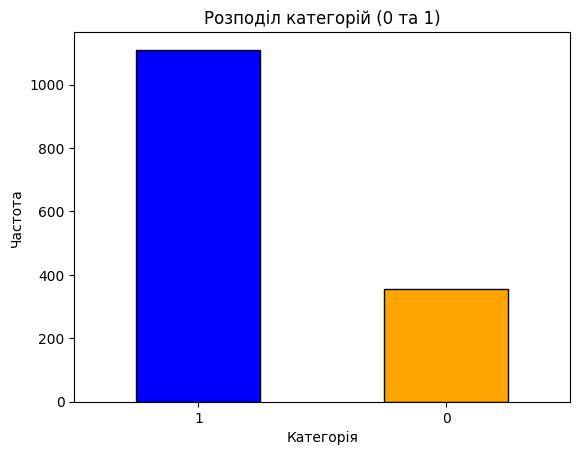

In [15]:
# Цільова змінна (замініть 'rating_category' на правильну назву стовпця)
y = df['rating_category']  # Перевірте, чи 'rating_category' - це правильна назва стовпця
y.head(500)
import matplotlib.pyplot as plt

# Припустимо, що df - це ваш DataFrame, і 'rating_category' - це стовпець із значеннями 0 та 1
df['rating_category'].value_counts().plot(kind='bar', edgecolor='black', color=['blue', 'orange'])

plt.xlabel('Категорія')
plt.ylabel('Частота')
plt.title('Розподіл категорій (0 та 1)')
plt.xticks(rotation=0)  # Якщо ви хочете позначки осі X були горизонтальними
plt.show()

Обробляємо дані для ембеддінгу. 

In [16]:
# Ініціалізація та адаптація TextVectorization
VOCAB_SIZE = 1000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)

max_seq_len = 200
X_sequences = tokenizer.texts_to_sequences(corpus)
X_padded = pad_sequences(X_sequences, maxlen=max_seq_len)

# Розділення на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

from sklearn.utils.class_weight import compute_class_weight

# Обчисліть ваги класів
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Створіть словник ваг класів
class_weight_dict = dict(enumerate(class_weights))

# Розмір словника (величина виходу Embedding-шару)
vocab_size = len(tokenizer.word_index) + 1  # додати 1 через індексацію з 1

# Розмір вхідного тексту (кількість слів у тексті)
input_length = max_seq_len

print("Кількість слів у словнику:", vocab_size)
print("Розмір вхідного тексту:", input_length)

Кількість слів у словнику: 15191
Розмір вхідного тексту: 200


Будуємо мережу з використаннім LSTM через сильну нестачу пам'яті при компіляції. 

In [17]:
emb_dim = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=input_length))
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='tanh')))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Додавання EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Навчання моделі зі збереженням історії та EarlyStopping
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Оцініть результати на тестовому наборі
results = model.evaluate(X_test, y_test)
print("Test loss, Test accuracy:", results)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1944448   
                                                                 
 bidirectional (Bidirection  (None, 200, 256)          263168    
 al)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 200, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 32)               

Тут можна зазначити, що точність досягнута попередніми методами була 82%. Можливо, причиною є недостатня кількість даних для нейронної мережі, в той час TF-IDF та CountVectorizer доволі ефективні і на невеликих об'ємах даних та простих задачах.